# Ideal Diode Example

The simplest way to model a solar cell is as an **ideal diode**, described by the following equation:
$$J(V,T) = J_L+J_0(\exp{\frac{qV}{nkT}}-1)$$
where $k=8.61733\times 10^{-5}$ eV/K is Boltzmann's constant, by convention $J_L$ (the light current) is negative and $J_0$ (the saturation current) is positive but strongly dependent on temperature, a dependence we can approximate as:
$$J_0 \approx B'T^{3/n}\exp{\frac{-E_{g0}}{nkT}}$$
We'll use the silicon zero-temperature bandgap, $E_{g0}=1.2$ eV, meaning we just need to fit for $B'$ in this equation.
$J_L$ is typically directly proportional to light intensity, which we will treat as fixed for this example, leaving us with two parameters to fit for: $B'$ and the ideality factor $n$.

In [1]:
import numpy as np
import sys
import math
import pandas as pd
sys.path.append('../../')
import bayesim.model as bym
import bayesim.param_list as byp
import deepdish as dd
from jupyterthemes import jtplot
jtplot.style('default')

## List the parameters
First, we list our fitting parameters.

In [2]:
fp = byp.param_list()
fp.add_fit_param(name='Bp',val_range=[10,1000],spacing='log',length=15,units='arb.')
fp.add_fit_param(name='n',val_range=[1,2],length=15)

We can inspect the `param_list` object and see what kind of information is inside...

In [3]:
fp.fit_params

[{'edges': array([   10.        ,    13.59356391,    18.47849797,    25.11886432,
            34.14548874,    46.41588834,    63.09573445,    85.76958986,
           116.59144012,   158.48931925,   215.443469  ,   292.86445646,
           398.10717055,   541.16952655,   735.64225446,  1000.        ]),
  'length': 15,
  'min_width': 1.0311772745930552,
  'name': 'Bp',
  'spacing': 'log',
  'units': 'arb.',
  'val_range': [10, 1000],
  'vals': array([  11.65914401,   15.84893192,   21.5443469 ,   29.28644565,
           39.81071706,   54.11695265,   73.56422545,  100.        ,
          135.93563909,  184.78497974,  251.18864315,  341.45488738,
          464.15888336,  630.95734448,  857.69589859])},
 {'edges': array([ 1.        ,  1.06666667,  1.13333333,  1.2       ,  1.26666667,
          1.33333333,  1.4       ,  1.46666667,  1.53333333,  1.6       ,
          1.66666667,  1.73333333,  1.8       ,  1.86666667,  1.93333333,  2.        ]),
  'length': 15,
  'min_width': 0.0066666666666

Note that there are both `edges` and `vals` computed - the `vals` will be the values at which computations will be done, while `edges` will be the edges of the grid, used in subdivision steps later on.

Finally, we define the measurement conditions. We won't be varying light intensity here, so we only need voltage and temperature.

In [4]:
ec = ['V','T']

In [5]:
m = bym.model(params=fp,ec=ec,output_var='J')

In [6]:
m.probs.points.head(11)

,Bp,Bp_min,Bp_max,n,n_min,n_max,new,prob,num_sub
0,11.659144,10.0,13.593564,1.033333,1.000000,1.066667,1.0,0.004444,0
1,11.659144,10.0,13.593564,1.100000,1.066667,1.133333,1.0,0.004444,0
2,11.659144,10.0,13.593564,1.166667,1.133333,1.200000,1.0,0.004444,0
3,11.659144,10.0,13.593564,1.233333,1.200000,1.266667,1.0,0.004444,0
4,11.659144,10.0,13.593564,1.300000,1.266667,1.333333,1.0,0.004444,0
5,11.659144,10.0,13.593564,1.366667,1.333333,1.400000,1.0,0.004444,0
6,11.659144,10.0,13.593564,1.433333,1.400000,1.466667,1.0,0.004444,0
7,11.659144,10.0,13.593564,1.500000,1.466667,1.533333,1.0,0.004444,0
8,11.659144,10.0,13.593564,1.566667,1.533333,1.600000,1.0,0.004444,0
9,11.659144,10.0,13.593564,1.633333,1.600000,1.666667,1.0,0.004444,0


## Attach experimental data
This is the next step that needs to be done before adding the model as it will use the experimental conditions we enumerate here to compute simulated outputs. For our "experimental" data here, we'll actually just simulate some ideal diodes so that we can directly see how good the Bayesian approach is at recovering true underlying parameters.

We'll use $n=1.36$ and $B'=258$ as our "true" parameters. (I have no idea what "realistic" values for $B'$ would be...)

In [7]:
def compute_ID(ec,params):
    J_L = -0.03 # treat as fixed for now
    V = ec['V']
    T = ec['T']
    V_th = 8.61733e-5 * T # thermal voltage, kT/q
    n = params['n']
    Bp = params['Bp']
    J0 = Bp*T**(3/n)*math.exp(-1.2/V_th/n)
    return J_L + J0*(math.exp(V/V_th/n)-1)

V = np.arange(0,1.0,0.05)
T = [float(t) for t in np.arange(150,301,50)]
params = {'n':1.36,'Bp':258}

data = []
for t in T:
    for v in V:
        data.append([v,t,compute_ID({'V':v,'T':t},params)])
        
data = pd.DataFrame.from_records(data=data,columns=['V','T','J'])
#dd.io.save('obs_data.h5',data)

In [8]:
m.attach_observations(fpath='obs_data.h5')

Identified experimental conditions as ['V', 'T']. If this is wrong, rerun and explicitly specify them with attach_ec (make sure they match data file columns) or remove extra columns from data file.


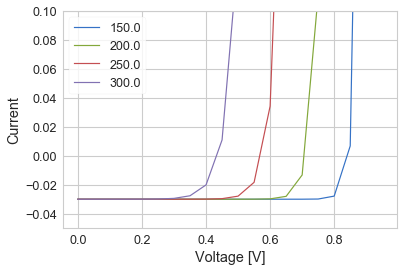

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
leg = []
for i in range(len(T)):
    curve = data.iloc[len(V)*i:len(V)*(i+1)]
    plt.plot(curve['V'],curve['J'])
    leg.append(curve['T'].iloc[0])
plt.ylim([-0.05,0.1])
plt.legend([str(t) for t in leg])
plt.xlabel('Voltage [V]')
plt.ylabel('Current')
plt.show()

In [10]:
#m.obs_data.head()

## Attach model
Now we add the function that gives the modeled data - in this case, the `compute_ID` function we just defined above.

In [11]:
m.attach_model(mode='function',func_name=compute_ID)
#m.attach_model(mode='file',fpath='model_data.h5')

That's it! When that function is called, `bayesim` also generates the full table of modeled data at all experimental conditions in the observed data we attached before. Check it out:

In [12]:
m.model_data.head(10)

,Bp,J,T,V,n
0,11.659144,-0.03,150.0,0.00,1.033333
1,11.659144,-0.03,150.0,0.05,1.033333
2,11.659144,-0.03,150.0,0.10,1.033333
3,11.659144,-0.03,150.0,0.15,1.033333
4,11.659144,-0.03,150.0,0.20,1.033333
5,11.659144,-0.03,150.0,0.25,1.033333
6,11.659144,-0.03,150.0,0.30,1.033333
7,11.659144,-0.03,150.0,0.35,1.033333
8,11.659144,-0.03,150.0,0.40,1.033333
9,11.659144,-0.03,150.0,0.45,1.033333


In [13]:
m.calc_model_gradients()

## Drop that Bayes!

In [14]:
m.run()

*****RUN 0*****
V      0.10
T    250.00
J     -0.03
Name: 42, dtype: float64
V       0.850000
T     300.000000
J    3568.727199
Name: 77, dtype: float64
V      0.05
T    250.00
J     -0.03
Name: 41, dtype: float64
V      0.800000
T    150.000000
J     -0.027863
Name: 16, dtype: float64
V      0.15
T    250.00
J     -0.03
Name: 43, dtype: float64
V      0.25
T    150.00
J     -0.03
Name: 5, dtype: float64
V      0.800000
T    200.000000
J      1.161187
Name: 36, dtype: float64
V      0.45
T    200.00
J     -0.03
Name: 29, dtype: float64
V      0.30
T    150.00
J     -0.03
Name: 6, dtype: float64
V      0.700000
T    150.000000
J     -0.029993
Name: 14, dtype: float64
Reached threshold!
*****RUN 1*****
V      0.700000
T    150.000000
J     -0.029993
Name: 14, dtype: float64
Reached threshold!
*****RUN 2*****
V      0.700000
T    150.000000
J     -0.029993
Name: 14, dtype: float64
Reached threshold!


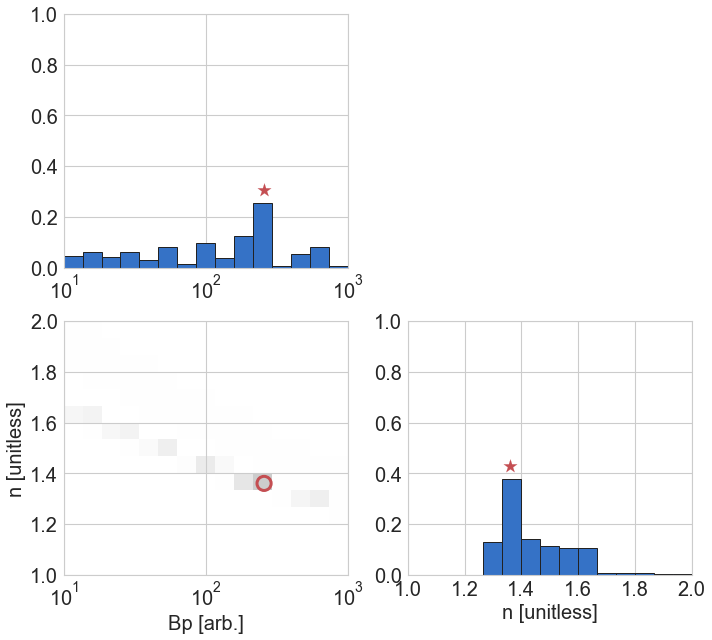

In [15]:
m.visualize_probs(true_vals=params)

In [16]:
m.probs.most_probable(10)

,Bp,Bp_min,Bp_max,n,n_min,n_max,new,prob,num_sub,start_ind,end_ind
155,251.188643,215.443469,292.864456,1.366667,1.333333,1.400000,1.0,0.248964,0,12400,12479
140,184.784980,158.489319,215.443469,1.366667,1.333333,1.400000,1.0,0.120379,0,11200,11279
111,100.000000,85.769590,116.591440,1.433333,1.400000,1.466667,1.0,0.094196,0,8880,8959
82,54.116953,46.415888,63.095734,1.500000,1.466667,1.533333,1.0,0.077118,0,6560,6639
199,630.957344,541.169527,735.642254,1.300000,1.266667,1.333333,1.0,0.076388,0,15920,15999
53,29.286446,25.118864,34.145489,1.566667,1.533333,1.600000,1.0,0.056730,0,4240,4319
24,15.848932,13.593564,18.478498,1.633333,1.600000,1.666667,1.0,0.055837,0,1920,1999
184,464.158883,398.107171,541.169527,1.300000,1.266667,1.333333,1.0,0.046733,0,14720,14799
9,11.659144,10.000000,13.593564,1.633333,1.600000,1.666667,1.0,0.040046,0,720,799
38,21.544347,18.478498,25.118864,1.566667,1.533333,1.600000,1.0,0.039418,0,3040,3119


In [17]:
m.subdivide()

42 box(es) with probability > 0.001 and 42 neighboring boxes subdivided!
New model points to simulate are saved in the file new_sim_points_1.h5.


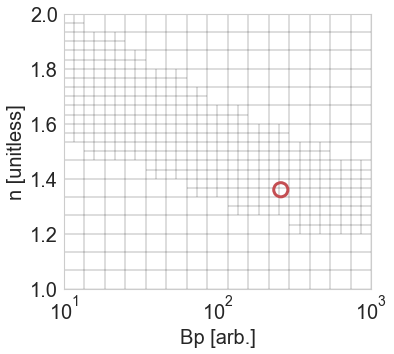

In [18]:
m.visualize_grid(true_vals=params)

In [19]:
new_sims = dd.io.load('new_sim_points_1.h5')

In [20]:
data = []
for sim in new_sims.iterrows():
    v = sim[1]['V']
    t = sim[1]['T']
    this_pt = [v,t,compute_ID({'V':v,'T':t},sim[1])]
    this_pt.extend([sim[1][n] for n in m.param_names])
    data.append(this_pt)
columns = ['V','T','J']
columns.extend(m.param_names)
new_sim_data = pd.DataFrame.from_records(data=data,columns=columns)
dd.io.save('new_sim_data_1.h5',new_sim_data)

In [21]:
m.attach_model(mode='add',fpath='new_sim_data_1.h5')

In [22]:
m.calc_model_gradients()

In [23]:
m.probs.uniformize()
m.run(th_pm=0.95,th_pv=0.02)

*****RUN 0*****
V      0.45
T    200.00
J     -0.03
Name: 29, dtype: float64
V      0.750000
T    150.000000
J     -0.029876
Name: 15, dtype: float64
V      0.300000
T    250.000000
J     -0.029998
Name: 46, dtype: float64
V      0.900000
T    150.000000
J      0.601509
Name: 18, dtype: float64
V      0.35
T    200.00
J     -0.03
Name: 27, dtype: float64
V      0.05
T    300.00
J     -0.03
Name: 61, dtype: float64
V      0.450000
T    300.000000
J      0.010884
Name: 69, dtype: float64
V      0.65000
T    200.00000
J     -0.02802
Name: 33, dtype: float64
V      0.600000
T    300.000000
J      2.883509
Name: 72, dtype: float64
V      0.700000
T    250.000000
J      1.918731
Name: 54, dtype: float64
V      0.650000
T    300.000000
J     12.049155
Name: 73, dtype: float64
V      0.800000
T    300.000000
J    860.759364
Name: 76, dtype: float64
V      0.15
T    250.00
J     -0.03
Name: 43, dtype: float64
V      0.40
T    150.00
J     -0.03
Name: 8, dtype: float64
V      0.85000
T    150.00

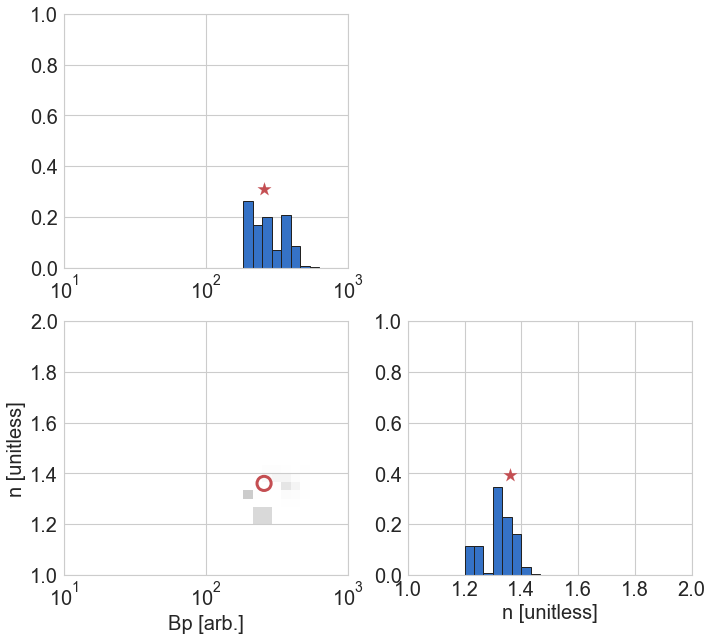

In [24]:
m.visualize_probs(true_vals=params)

In [25]:
m.probs.most_probable(10)

,Bp,Bp_max,Bp_min,end_ind,n,n_max,n_min,new,num_sub,prob,start_ind
324,199.526231,215.443469,184.784980,30159,1.316667,1.333333,1.300000,1.0,1,0.304107,30080
346,251.188643,292.864456,215.443469,7439,1.233333,1.266667,1.200000,0.0,0,0.226955,7360
387,368.694506,398.107171,341.454887,33599,1.350000,1.366667,1.333333,1.0,1,0.155437,33520
397,429.866235,464.158883,398.107171,34399,1.350000,1.366667,1.333333,1.0,1,0.064175,34320
368,316.227766,341.454887,292.864456,32879,1.383333,1.400000,1.366667,1.0,1,0.060018,32800
388,368.694506,398.107171,341.454887,33679,1.383333,1.400000,1.366667,1.0,1,0.057175,33600
356,271.227258,292.864456,251.188643,31919,1.383333,1.400000,1.366667,1.0,1,0.026904,31840
386,368.694506,398.107171,341.454887,33519,1.316667,1.333333,1.300000,1.0,1,0.023255,33440
398,429.866235,464.158883,398.107171,34479,1.383333,1.400000,1.366667,1.0,1,0.014132,34400
396,429.866235,464.158883,398.107171,34319,1.316667,1.333333,1.300000,1.0,1,0.013361,34240


In [26]:
m.subdivide()

20 box(es) with probability > 0.001 and 27 neighboring boxes subdivided!
New model points to simulate are saved in the file new_sim_points_2.h5.


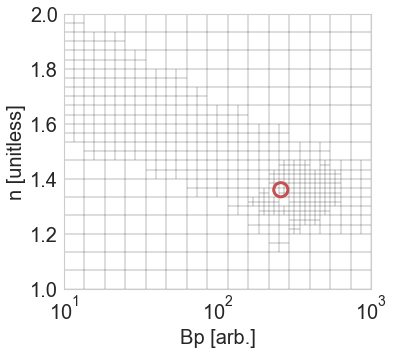

In [27]:
m.visualize_grid(true_vals=params)

In [28]:
new_sims = dd.io.load('new_sim_points_2.h5')
data = []
for sim in new_sims.iterrows():
    v = sim[1]['V']
    t = sim[1]['T']
    this_pt = [v,t,compute_ID({'V':v,'T':t},sim[1])]
    this_pt.extend([sim[1][n] for n in m.param_names])
    data.append(this_pt)
columns = ['V','T','J']
columns.extend(m.param_names)
new_sim_data = pd.DataFrame.from_records(data=data,columns=columns)
dd.io.save('new_sim_data_2.h5',new_sim_data)
m.attach_model(mode='add',fpath='new_sim_data_2.h5')
m.calc_model_gradients()

In [29]:
m.probs.uniformize()
m.run(th_pm=0.98,th_pv=0.015)

*****RUN 0*****
V      0.05
T    150.00
J     -0.03
Name: 1, dtype: float64
V      0.700000
T    150.000000
J     -0.029993
Name: 14, dtype: float64
V      0.600000
T    300.000000
J      2.883509
Name: 72, dtype: float64
V      0.250000
T    300.000000
J     -0.029862
Name: 65, dtype: float64
V      0.500000
T    200.000000
J     -0.029997
Name: 30, dtype: float64
Reached threshold!
*****RUN 1*****
V      0.500000
T    200.000000
J     -0.029997
Name: 30, dtype: float64
V      0.950000
T    200.000000
J    716.559345
Name: 39, dtype: float64
V      0.800000
T    150.000000
J     -0.027863
Name: 16, dtype: float64
V      0.200000
T    300.000000
J     -0.029967
Name: 64, dtype: float64
V      0.05
T    300.00
J     -0.03
Name: 61, dtype: float64
V      0.900000
T    150.000000
J      0.601509
Name: 18, dtype: float64
Reached threshold!
*****RUN 2*****
V      0.900000
T    150.000000
J      0.601509
Name: 18, dtype: float64
V      0.650000
T    300.000000
J     12.049155
Name: 73, dtype

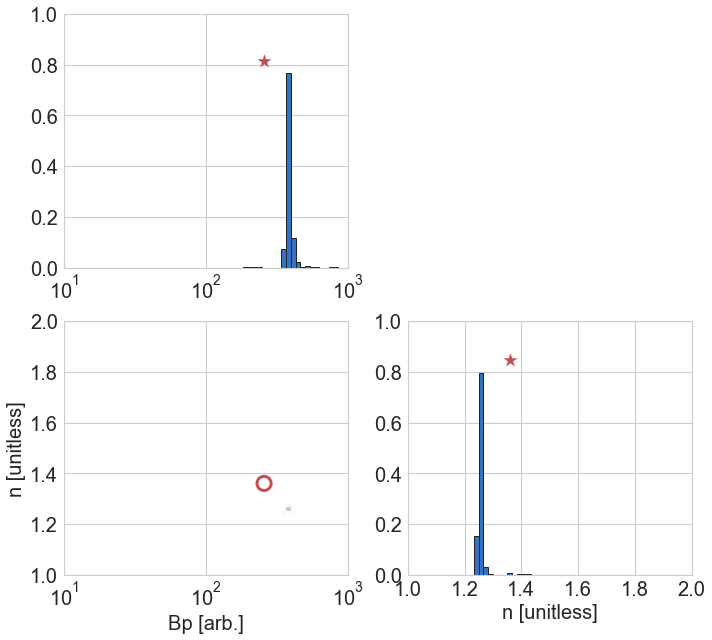

In [30]:
m.visualize_probs(true_vals=params)

In [31]:
m.probs.most_probable(5)

,Bp,Bp_max,Bp_min,end_ind,n,n_max,n_min,new,num_sub,prob,start_ind
473,383.118685,398.107171,368.694506,43359,1.258333,1.266667,1.250000,1.0,2,0.731006,43280
455,354.813389,368.694506,341.454887,42159,1.241667,1.250000,1.233333,1.0,2,0.068465,42080
487,413.682040,429.866235,398.107171,44479,1.258333,1.266667,1.250000,1.0,2,0.058043,44400
486,413.682040,429.866235,398.107171,44399,1.241667,1.250000,1.233333,1.0,2,0.055367,44320
474,383.118685,398.107171,368.694506,43439,1.275000,1.283333,1.266667,1.0,2,0.026367,43360


In [32]:
m.probs.params

[{'edges': array([   10.        ,    13.59356391,    18.47849797,    25.11886432,
            34.14548874,    46.41588834,    63.09573445,    85.76958986,
           116.59144012,   158.48931925,   215.443469  ,   292.86445646,
           398.10717055,   541.16952655,   735.64225446,  1000.        ]),
  'length': 15,
  'min_width': 1.0311772745930552,
  'name': 'Bp',
  'spacing': 'log',
  'units': 'arb.',
  'val_range': [10, 1000],
  'vals': array([  11.65914401,   15.84893192,   21.5443469 ,   29.28644565,
           39.81071706,   54.11695265,   73.56422545,  100.        ,
          135.93563909,  184.78497974,  251.18864315,  341.45488738,
          464.15888336,  630.95734448,  857.69589859])},
 {'edges': array([ 1.        ,  1.06666667,  1.13333333,  1.2       ,  1.26666667,
          1.33333333,  1.4       ,  1.46666667,  1.53333333,  1.6       ,
          1.66666667,  1.73333333,  1.8       ,  1.86666667,  1.93333333,  2.        ]),
  'length': 15,
  'min_width': 0.0066666666666